In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np
import umap
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Prep data

In [2]:
# Prep training data
training_data = pd.read_excel("drug_data_trajectories.xlsx",sheet_name='train')

y_train = training_data['Drug Name']
X_train = training_data.drop(columns=['Drug Name'])

training_data

,Drug Name,Concentration (mM),T25,T26,T27,T28,T29,T30,T31,T32,T33,T34,T35,T36,T37,T38,T39,T40
0,Fentanyl,0,100.000000,92.825365,100.461579,92.469817,86.496792,80.661569,64.268772,50.350061,37.267764,27.521156,21.363218,18.085617,15.440689,14.554591,13.614447,12.971793
1,Fentanyl,2,114.551294,108.226430,109.563694,101.546899,92.327980,85.967309,72.666348,55.804172,24.025181,10.256519,7.030723,5.445027,4.459984,4.102041,3.842967,3.854784
2,Fentanyl,4,100.925289,98.476665,94.333656,88.037290,79.007199,70.903336,60.163533,50.582466,28.928994,10.584410,5.436675,3.956702,3.221069,2.881819,2.572369,2.523481
3,Fentanyl,6,88.579522,87.431246,82.035154,75.451290,69.876852,63.826349,53.170001,45.394162,28.973436,10.311773,4.511629,3.121284,2.498427,2.223310,1.948349,1.963360
4,Fentanyl,8,97.798757,94.478575,87.565561,80.106299,72.833861,67.349338,55.847019,46.953359,30.619634,12.971793,6.086019,4.463409,3.569987,3.169567,2.818383,2.818383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,Isoniazid,2,111.943788,109.816264,106.414302,107.151931,106.169556,104.712855,102.643945,100.076782,98.552278,98.250175,98.250175,97.798757,97.349412,97.349412,97.498964,97.573826
98,Isoniazid,4,103.593697,98.099471,94.841846,94.188960,93.039350,90.991327,89.536477,86.629671,85.638030,85.506671,86.099375,86.962764,87.700082,88.988387,89.742879,90.642804
99,Isoniazid,6,119.398810,114.815362,111.002647,109.732010,108.226430,106.006704,105.357794,104.873718,104.873718,105.844103,106.823466,107.398941,108.392691,109.732010,111.173173,112.287997
100,Isoniazid,8,120.688716,116.591440,115.877736,113.937495,113.937495,112.892910,111.857901,110.747348,110.492636,110.407862,110.662378,111.087877,111.515011,111.943788,112.201845,112.633263


In [3]:
# Prep testing data
test_data = pd.read_excel("drug_data_trajectories.xlsx",sheet_name='test')

y_test = test_data['Drug Name']
X_test = test_data.drop(columns=['Drug Name'])

test_data

,Drug Name,Concentration (mM),T25,T26,T27,T28,T29,T30,T31,T32,T33,T34,T35,T36,T37,T38,T39,T40
0,Fentanyl,2,112.201845,105.357794,114.200148,111.343961,101.780989,93.110788,81.096106,69.662651,40.457589,14.498843,8.407496,6.358188,5.227973,4.897788,4.525501,4.567375
1,Fentanyl,4,115.168400,109.732010,130.617089,121.711982,114.287833,106.332657,92.044957,82.921408,66.221650,29.648314,13.583134,9.682779,7.750564,7.014553,6.476395,6.481368
2,Fentanyl,6,87.632796,84.268772,91.341190,84.010454,77.149539,69.716140,57.765251,49.279542,37.011214,16.943378,5.662393,3.591975,2.835742,2.479324,2.250781,2.268123
3,Fentanyl,8,104.391867,97.648745,104.632516,95.572585,86.696188,77.983011,66.018654,58.299747,47.716290,24.154608,8.763280,5.865882,4.549881,4.120975,3.813584,3.790240
4,Fentanyl,10,84.918048,93.756201,103.752842,96.530969,87.163234,78.162780,65.313055,55.804172,35.291220,12.618275,7.550922,6.227781,5.710402,5.432503,5.370318,5.486979
5,Ibuprofen Sodium,0,100.000000,88.443652,82.035154,71.669328,56.798038,40.863290,33.087707,27.268840,23.334581,20.307977,18.169097,16.368165,15.511960,14.223288,13.233255,12.236766
6,Ibuprofen Sodium,2,95.792903,82.730694,75.509223,66.783114,57.147864,44.908995,37.210599,30.432199,25.684237,22.908677,20.276827,18.183047,16.634127,15.691580,14.599344,14.038908
7,Ibuprofen Sodium,4,107.069720,92.469817,84.463032,74.587606,63.826349,51.562425,45.324533,36.419446,30.432199,26.586837,23.659197,21.346827,19.663765,18.549548,17.418069,16.672472
8,Ibuprofen Sodium,6,115.256829,100.693167,91.762802,81.532983,68.812394,58.031884,51.681289,43.484385,35.345435,30.315635,26.894698,24.547089,22.908677,21.428906,19.588447,18.492686
9,Ibuprofen Sodium,8,115.699993,102.015618,90.712402,80.290963,69.823240,57.720932,52.199539,44.463127,37.039632,31.429200,27.143551,23.804917,21.346827,19.967943,18.578045,17.258379


In [4]:
# Scale all data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# XGBoost Classifier

In [5]:
# Encode y_test and y_train
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [6]:
# Define base model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

In [ ]:
# Hyperparameter tuning
param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [50, 100],
    'subsample': [0.8, 1.0]
}

# Nested (Outer) Cross-Validation
from sklearn.model_selection import StratifiedKFold
from collections import Counter

X_all = X_train 
y_all = y_train

outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_params_list = []

for tr_idx, val_idx in outer.split(X_all, y_all):
    X_tr, X_val = X_all.iloc[tr_idx], X_all.iloc[val_idx]
    y_tr, y_val = y_all.iloc[tr_idx], y_all.iloc[val_idx]

    # Scale within each outer fold (prevents leakage)
    scaler_cv = StandardScaler()
    X_tr_scaled = scaler_cv.fit_transform(X_tr)
    X_val_scaled = scaler_cv.transform(X_val)

    # Encode labels within the fold
    le_cv = LabelEncoder().fit(y_tr)
    y_tr_enc = le_cv.transform(y_tr)
    y_val_enc = le_cv.transform(y_val)

    # Base model
    xgb_cv = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

    # Inner CV tuning on the training part of this fold
    inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    gs = GridSearchCV(
        estimator=xgb_cv,
        param_grid=param_grid,
        cv=inner,
        scoring='accuracy',
        n_jobs=-1,
        verbose=0
    )
    gs.fit(X_tr_scaled, y_tr_enc)
    best_params_list.append(gs.best_params_)

# Choose the most frequent best params across outer folds
consensus_params = dict(Counter(tuple(sorted(p.items())) for p in best_params_list).most_common(1)[0][0])

# Final refit on training data then predict test
xgb_final = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',
                          random_state=42, **consensus_params)
xgb_final.fit(X_train_scaled, y_train_encoded)
best_model = xgb_final

# Predict test set
y_pred_encoded = best_model.predict(X_test_scaled)

# Reverse encode y labels
y_pred = le.inverse_transform(y_pred_encoded)
y_test_labels = le.inverse_transform(y_test_encoded)

best_params_for_print = consensus_params


c:\Users\ASUS\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:01:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\ASUS\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:01:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\ASUS\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:02:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\ASUS\anaconda3\Lib\site-packages\xgbo

In [9]:
print("Best Parameters (from nested CV):")
print(best_params_for_print)


Best Parameters (from nested CV):
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


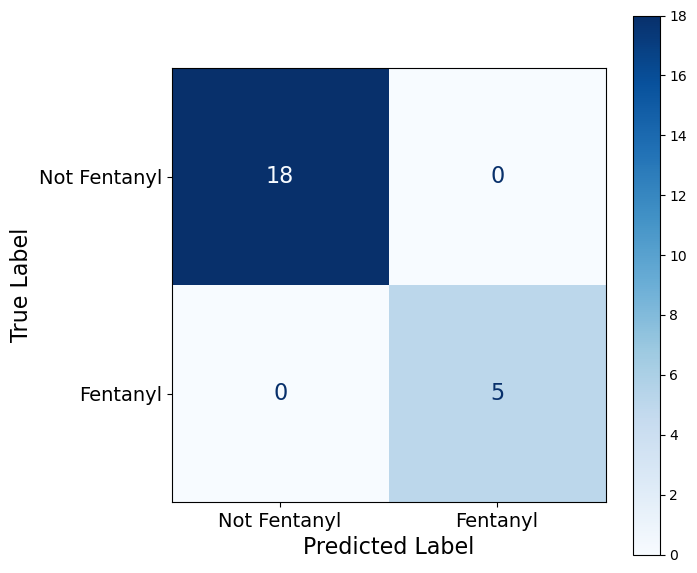

True Positives:  5
False Positives: 0
False Negatives: 0
True Negatives:  18

Precision: 1.00
Recall:    1.00
F1 Score:  1.00
Accuracy:  1.00
Matthews Correlation Coefficient (MCC): 1.00


In [11]:
# Plot confusion matrix
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    matthews_corrcoef
)

# Convert labels to binary, 1 = Fentanyl, 0 = Not Fentanyl
y_true_binary = [1 if label == 'Fentanyl' else 0 for label in y_test_labels]
y_pred_binary = [1 if label == 'Fentanyl' else 0 for label in y_pred]

# Confusion matrix
cm = confusion_matrix(y_true_binary, y_pred_binary)
tn, fp, fn, tp = cm.ravel()


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fentanyl', 'Fentanyl'])
fig, ax = plt.subplots(figsize=(7, 7))
disp.plot(cmap='Blues', ax=ax)

for row in disp.text_:
    for text in row:
        text.set_fontsize(16)

plt.xlabel('Predicted Label', size=16)
plt.ylabel('True Label', size=16)
plt.xticks(size=14)
plt.yticks(size=14)

plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')

plt.show()

#_____________________________________________________________________________
# Metrics
precision = precision_score(y_true_binary, y_pred_binary)
recall = recall_score(y_true_binary, y_pred_binary)
f1 = f1_score(y_true_binary, y_pred_binary)
accuracy = accuracy_score(y_true_binary, y_pred_binary)
mcc = matthews_corrcoef(y_true_binary, y_pred_binary)

print(f"True Positives:  {tp}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Negatives:  {tn}\n")

print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")
print(f"Accuracy:  {accuracy:.2f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc:.2f}")


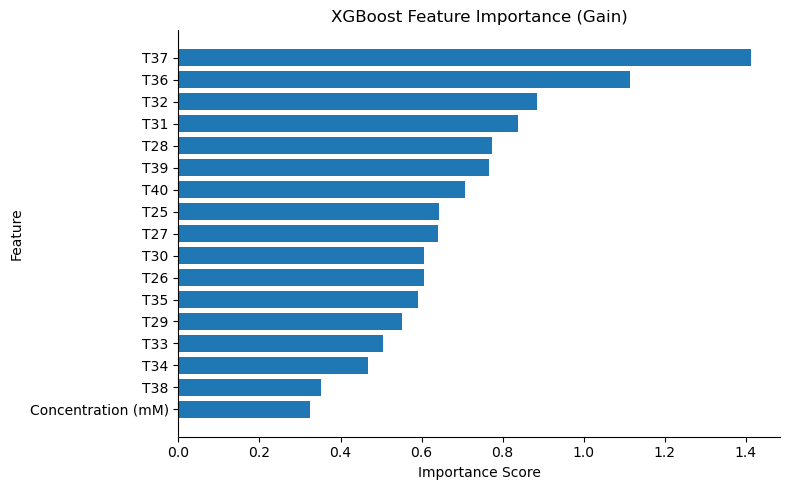

In [ ]:
# Get feature names
features = ['Concentration (mM)','T25','T26','T27','T28','T29','T30','T31','T32','T33','T34','T35','T36','T37','T38','T39','T40']

# Get feature importances by gain
importances = best_model.get_booster().get_score(importance_type='gain')

# Convert feature map to ordered list
importance_scores = []
for i, feature in enumerate(features):
    key = f'f{i}'
    score = importances.get(key, 0)
    importance_scores.append((feature, score))

# Sort by importance
importance_scores = sorted(importance_scores, key=lambda x: x[1], reverse=True)

# Plot
feat_names, scores = zip(*importance_scores)

plt.figure(figsize=(8, 5))
plt.barh(feat_names, scores)
plt.gca().invert_yaxis()
plt.title("XGBoost Feature Importance (Gain)")
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
